## 【分位点回帰】楽観的予測〜悲観的予測

### 内容
* Qiitaの記事と連動しています
* statsmodels.apiを利用して分位点回帰の演習を行います
* 分位点を利用した線形回帰モデルの演習です。statsmodelsを使えばOLSによる回帰分析同様簡単に求めることができます

## OLSと分位点回帰比較
* 3種類の分位点（0.1, 0.5, 0.9）を線形モデルで比較
* OLSと分位点（0.5）で比較

### スポーツ飲料と気温の関係
* [全国清涼飲料連合会](https://www.j-sda.or.jp/index.php)
* [気象庁共同プロジェクト](https://www.j-sda.or.jp/about/comprehensive_measures/weather/kekka04.php)
* 気象庁共同プロジェクトからDL4.xlsファイルをダウンロード、sports_temp.csvとファイル名を変更して利用します

### データの読み込みとグラフ表示
* 利用するのは平均気温と販売指数

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./data/sports_temp.csv")
df.head(5)

,年月日,平均気温,販売指数,週別指数,週別気温
0,2014/4/1,13.9,2.263703,NaN,NaN
1,2014/4/2,15.2,1.697737,NaN,NaN
2,2014/4/3,13.8,1.407450,NaN,NaN
3,2014/4/4,15.3,1.209598,NaN,NaN
4,2014/4/5,11.4,1.206834,1.227821,13.157143


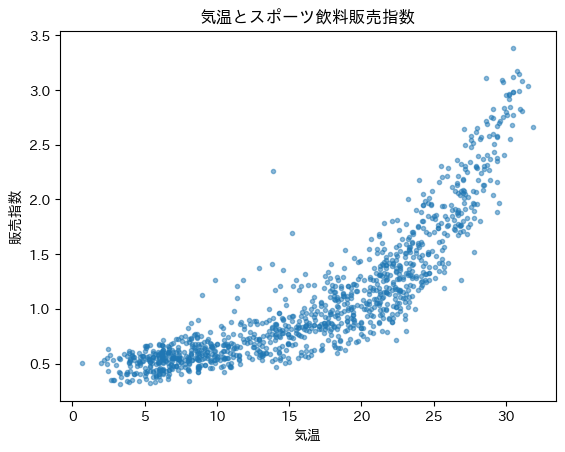

In [3]:
plt.scatter(df["平均気温"], df["販売指数"], alpha=0.5, marker=".")

plt.title("気温とスポーツ飲料販売指数")
plt.xlabel("気温")
plt.ylabel("販売指数")
plt.show()

### 訓練データとテストデータに分割

* 訓練データで分位点回帰の推定を行います
* テストデータが推定式の予測の範囲に収まるか確認します

In [4]:
x = df["平均気温"]
t = df["販売指数"]
x_train, x_test, t_train, t_test = train_test_split(x,t, random_state=55)
x_train.shape, x_test.shape, t_train.shape, t_test.shape

((844,), (282,), (844,), (282,))

### 分位点回帰の基本的な実装パターン
* 全データによる推定

In [5]:
# 説明変数と目的変数を設定
y = df["販売指数"]
X = sm.add_constant(df["平均気温"])

tau = 0.5

# --- 分位点回帰の実行（例：中央値回帰 τ=0.5）---
model = sm.QuantReg(endog=y, exog=X)
result = model.fit(q=tau)

print(f"分位点：{tau}")
print(result.summary())
print(f"切片：{result.params.const:.3f}")
print(f"平均気温係数：{result.params.平均気温:.3f}")

分位点：0.5
                         QuantReg Regression Results                          
Dep. Variable:                   販売指数   Pseudo R-squared:               0.5008
Model:                       QuantReg   Bandwidth:                      0.1176
Method:                 Least Squares   Sparsity:                       0.6160
Date:                Sun, 31 Aug 2025   No. Observations:                 1126
Time:                        09:37:28   Df Residuals:                     1124
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0890      0.022      4.122      0.000       0.047       0.131
平均気温           0.0574      0.001     48.290      0.000       0.055       0.060
切片：0.089
平均気温係数：0.057


### 3種類の分位点を利用したグラフ

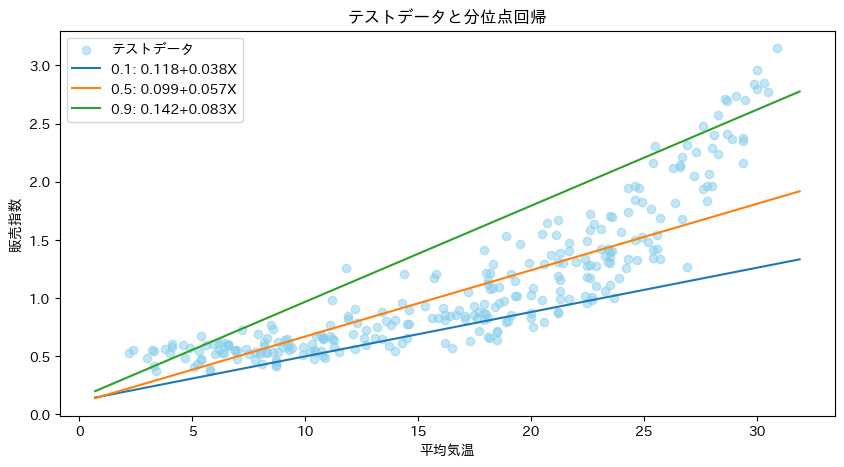

In [6]:
taus = [0.1, 0.5, 0.9]

# 説明変数と目的変数を設定
# 訓練データで学習
y = t_train
X = sm.add_constant(x_train)

# 分位点回帰モデル
model = sm.QuantReg(endog=y, exog=X)


# 予測曲線を滑らかに描くために、気温の範囲を細かく設定
temp_range = np.linspace(df["平均気温"].min(), df["平均気温"].max(), 100)
predict_df = pd.DataFrame({"平均気温": temp_range})
predict_df = sm.add_constant(predict_df)


# グラフ描画
fig, ax = plt.subplots(figsize=(10,5))

# 実際のデータとテストデータの散布図
ax.scatter(x_test, t_test, color="skyblue", label="テストデータ", alpha=0.5)

# 3種類の分位点を利用したグラフ
for t in taus:
    result = model.fit(q=t)
    a = result.params.const
    b = result.params.平均気温
    label = f"{t}: {a:.3f}+{b:.3f}X"
    # モデルを使って予測値を計算
    predicted_sales = result.predict(predict_df)
    # 予測曲線をプロット
    ax.plot(temp_range, predicted_sales, label=label)

ax.set_title("テストデータと分位点回帰")
ax.set_xlabel("平均気温")
ax.set_ylabel("販売指数")
ax.legend()
plt.show()

### OLS線形回帰と分位点回帰の比較
* 平均の予測であるOLSによる線形回帰直線を追加
* 中央値予測である分位点0.5による線形回帰直線とOLSによる線形回帰直線を比較してみる

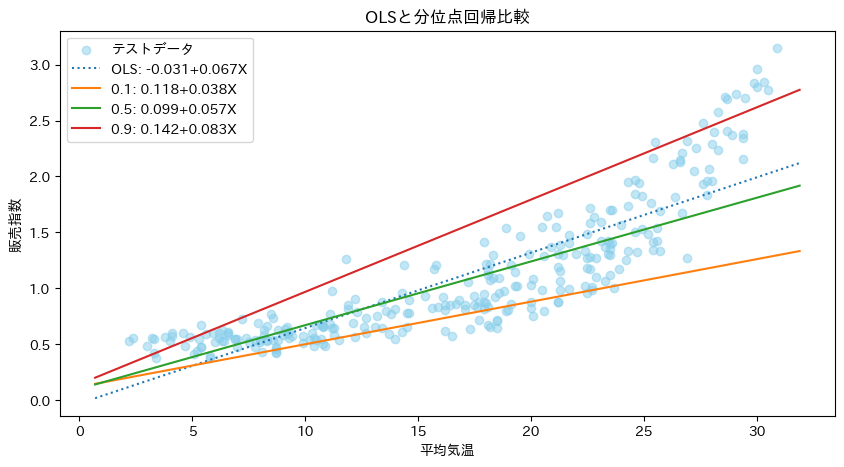

In [7]:
taus = [0.1, 0.5, 0.9]

# 訓練データで学習
y = t_train
X = sm.add_constant(x_train)


# OLS線形回帰
ols_model = sm.OLS(endog=y, exog=X)
ols_result = ols_model.fit()
ols_a = ols_result.params.const
ols_b = ols_result.params.平均気温
ols_label = f"OLS: {ols_a:.3f}+{ols_b:.3f}X"

# 分位点回帰モデル
model = sm.QuantReg(endog=y, exog=X)


# 予測曲線を滑らかに描くために、気温の範囲を細かく設定
temp_range = np.linspace(df["平均気温"].min(), df["平均気温"].max(), 100)
predict_df = pd.DataFrame({"平均気温": temp_range})
predict_df = sm.add_constant(predict_df)


# グラフ描画
fig, ax = plt.subplots(figsize=(10,5))

# 実際のデータとテストデータの散布図
ax.scatter(x_test, t_test, color="skyblue", label="テストデータ", alpha=0.5)


# OLS線形回帰のプロット
# 平均気温が一定間隔で並んでいるpredict_dfを使って直線を描画
ols_predicted_sales = ols_result.predict(predict_df)
ax.plot(temp_range, ols_predicted_sales, label=ols_label, linestyle="dotted")


for t in taus:
    result = model.fit(q=t)
    a = result.params.const
    b = result.params.平均気温
    label = f"{t}: {a:.3f}+{b:.3f}X"
    # モデルを使って予測値を計算
    predicted_sales = result.predict(predict_df)
    # 予測曲線をプロット
    ax.plot(temp_range, predicted_sales, label=label)

ax.set_title("OLSと分位点回帰比較")
ax.set_xlabel("平均気温")
ax.set_ylabel("販売指数")
ax.legend()
plt.show()